# 0. IMPORTS

In [1]:
import pandas as pd
import pymysql
from sqlalchemy import create_engine
import getpass
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np

# 1. CONNECTION BETWEEN PYTHON AND SQL

Before importing telco_general_table, some queries must be performed in a SQL ecosystem. Within this repository are:

> Check_sql_queries | Here are the queries focused on checking the original tables: data formats, checking the information of the columns and their values...

> Main_table_unifying_queries | Here are the queries related to the final table (telco_general_table) such as its creation, name cleaning, filling anomalous values...

In [2]:
password = getpass.getpass() # Getting the password in a safe way.

# BD configuration and conexion to MySQL server.
bd = "telco_churn_proyect"
connection_string = 'mysql+pymysql://root:' + password + '@localhost/' + bd
engine = create_engine(connection_string)

# Make a query about to read our main table and turn into a Pandas Dataframe.
consulta = "SELECT * FROM telco_churn_proyect.telco_general_table"
df = pd.read_sql(consulta, con=engine)

In [4]:
df.to_csv('telco_general_table.csv', index=False) #Saving our main table as CSV in Local. 

# 2. STATISTICS

## Logic Regression Model

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


# We codify categorical variables as 1 or 0.
df['married'] = df['married'].map({'Yes': 1, 'No': 0})
df['gender'] = df['gender'].map({'Male': 1, 'Female': 0})

# We define the independent (x) and dependent (y) variables.
X = df[['age', 'married', 'gender']]
y = df['churn_value']

# Adding a constant for the logistic regression.
X = sm.add_constant(X)

# We divide our data into training and test (optional, just for validation).
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Adjust the logistic regression model.
logit_model = sm.Logit(y_train, X_train)
result = logit_model.fit()

# Print the model result:
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.558931
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:            churn_value   No. Observations:                 4853
Model:                          Logit   Df Residuals:                     4849
Method:                           MLE   Df Model:                            3
Date:                Thu, 19 Sep 2024   Pseudo R-squ.:                 0.03544
Time:                        15:35:22   Log-Likelihood:                -2712.5
converged:                       True   LL-Null:                       -2812.2
Covariance Type:            nonrobust   LLR p-value:                 5.823e-43
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.4671      0.110    -13.347      0.000      -1.682      -1.252
age            0.0168      0.

### Coefficient chart

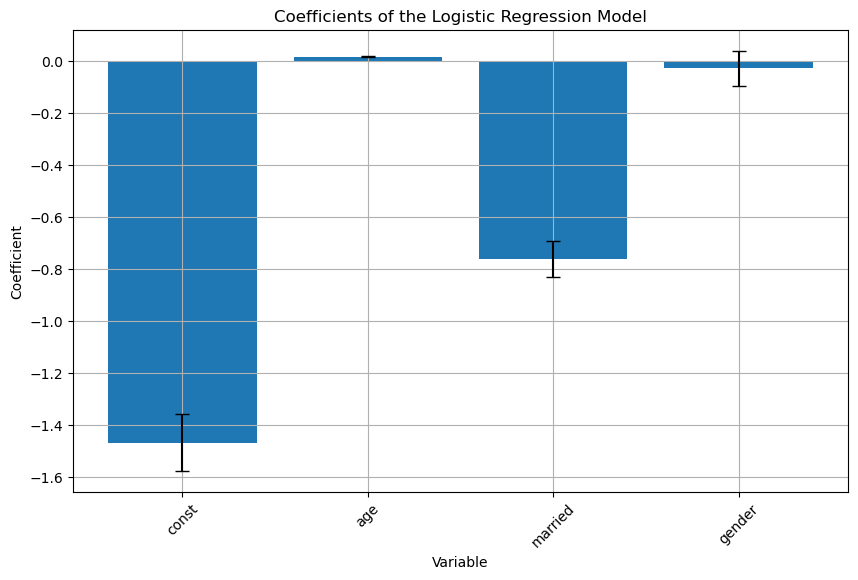

In [7]:
# Obtain the coefficients of the model
coef = result.params
errors = result.bse

# Create a DataFrame for the coefficients and errors
coef_df = pd.DataFrame({
    'Variable': coef.index,
    'Coefficient': coef.values,
    'Standar error': errors.values
})

# Create chart
plt.figure(figsize=(10, 6))
plt.bar(coef_df['Variable'], coef_df['Coefficient'], yerr=coef_df['Standar error'], capsize=5)
plt.xlabel('Variable')
plt.ylabel('Coefficient')
plt.title('Coefficients of the Logistic Regression Model')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### Predicted Churn Probability Chart

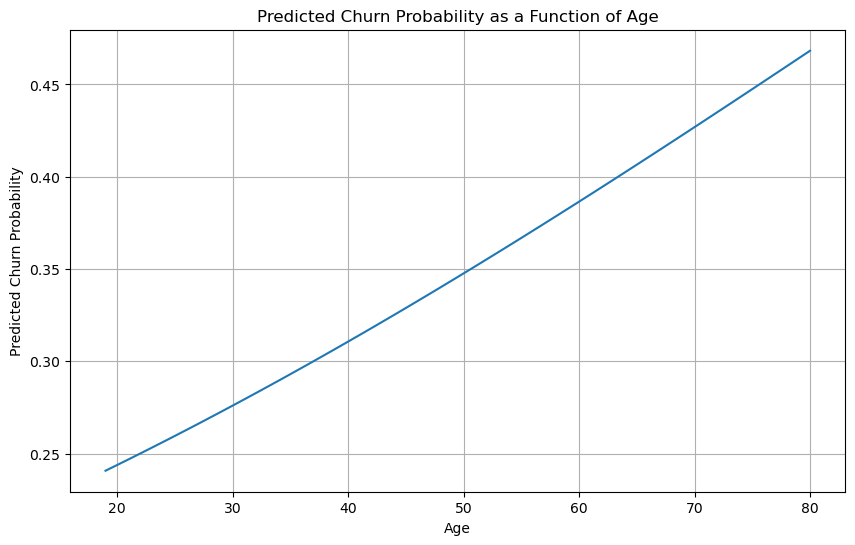

In [8]:
# Create a range of values ​​for age
age_range = np.linspace(df['age'].min(), df['age'].max(), 100)

# Create a DataFrame with these values
age_df = pd.DataFrame({'age': age_range, 'married': 0, 'gender': 0})
age_df = sm.add_constant(age_df)

# Predicting churn probabilities
predicted_probs = result.predict(age_df)

# Create the chart
plt.figure(figsize=(10, 6))
plt.plot(age_range, predicted_probs, label='Predicted Churn Probability')
plt.xlabel('Age')
plt.ylabel('Predicted Churn Probability')
plt.title('Predicted Churn Probability as a Function of Age')
plt.grid(True)
plt.show()

## Heatmap

In [9]:
# Filter the data to get only the customers with positive churn_value
positive_churn_df = df[df['churn_value'] == 1]

# Select the relevant columns
coords_df = positive_churn_df[['latitude', 'longitude']]

C:\Users\Carlos\AppData\Local\Temp\ipykernel_14932\2311757800.py:6: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


None


C:\Users\Carlos\AppData\Local\Temp\ipykernel_14932\2311757800.py:28: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  usa.plot(ax=ax, color='lightgrey')


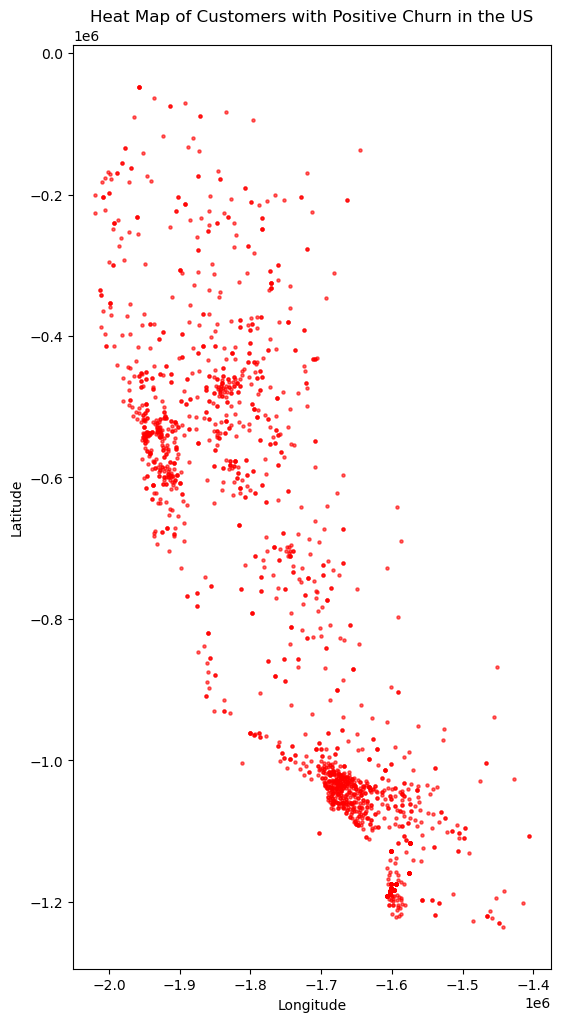

In [10]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

# Load US States Map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
usa = world[world.name == "United States"]

# Convert coordinates to a GeoDataFrame
gdf = gpd.GeoDataFrame(coords_df, geometry=gpd.points_from_xy(coords_df.longitude, coords_df.latitude))

# Check gdf and CRS
print(gdf.crs)

# If the CRS is not defined, configure it
if gdf.crs is None:
    gdf.crs = 'EPSG:4326'

# Project to a suitable CRS for viewing
gdf = gdf.to_crs(epsg=2163)

# Chart
fig, ax = plt.subplots(figsize=(12, 12))

# Make sure the CRS for `USA` and `gdf` match
usa = usa.to_crs(epsg=2163)

usa.plot(ax=ax, color='lightgrey')
gdf.plot(ax=ax, color='red', markersize=5, alpha=0.6)

plt.title('Heat Map of Customers with Positive Churn in the US')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [13]:
import folium
from folium.plugins import HeatMap

# Crear un mapa centrado en EE.UU.
m = folium.Map(location=[37.0902, -95.7129], zoom_start=5)

# Convertir el DataFrame en una lista de coordenadas
heat_data = [[row['latitude'], row['longitude']] for index, row in positive_churn_df.iterrows()]

# Añadir el mapa de calor
HeatMap(heat_data).add_to(m)

# Mostrar el mapa
m.save('heatmap.html')

## Average revenue of those who switch versus those who do not

In [14]:
# Filter data based on churn_value
positive_churn_df = df[df['churn_value'] == 1]
no_churn_df = df[df['churn_value'] == 0]

# Calculate the average total_revenue for each group
mean_revenue_positive_churn = positive_churn_df['total_revenue'].mean()
mean_revenue_no_churn = no_churn_df['total_revenue'].mean()

# Print results
print(f"Average profit for customers with positive churn_value: {mean_revenue_positive_churn:.2f}")
print(f"Average profit for customers with churn_value equal to 0: {mean_revenue_no_churn:.2f}")

Average profit for customers with positive churn_value: 1964.75
Average profit for customers with churn_value equal to 0: 3417.95


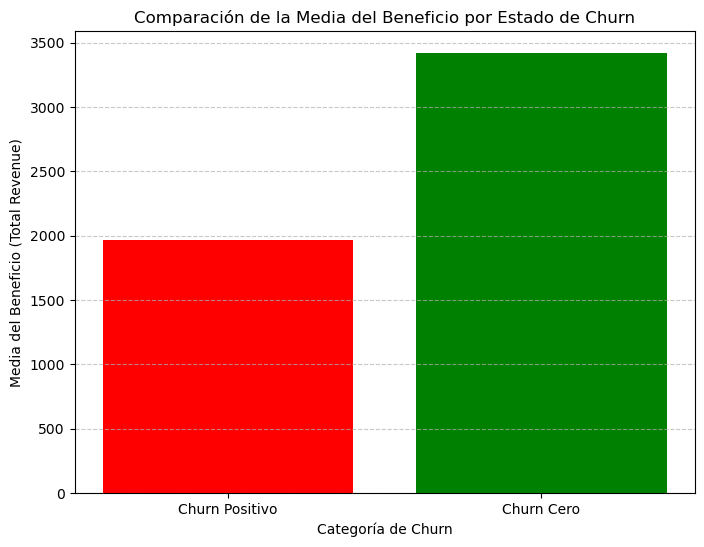

In [15]:
# Calcular la media del total_revenue para cada grupo
mean_revenue_positive_churn = positive_churn_df['total_revenue'].mean()
mean_revenue_no_churn = no_churn_df['total_revenue'].mean()

# Crear los datos para el gráfico
categories = ['Churn Positive', 'Churn Zero']
mean_revenues = [mean_revenue_positive_churn, mean_revenue_no_churn]

# Crear el gráfico de barras
plt.figure(figsize=(8, 6))
plt.bar(categories, mean_revenues, color=['red', 'green'])
plt.xlabel('Churn Category')
plt.ylabel('Average revenue (Total Revenue)')
plt.title('Comparison of Average Revenue by Churn Status')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()